In [ ]:
### 9.1.4

In [1]:
from nilearn import datasets
# By default 2nd subject will be fetched
haxby_dataset = datasets.fetch_haxby()
# 'func' is a list of filenames: one for each subject
fmri_filename = haxby_dataset.func[0]

# print basic information on the dataset
print('First subject functional nifti images (4D) are at: %s' %
      fmri_filename)  # 4D data


Dataset created in /home/pierre/nilearn_data/haxby2001



 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


Downloaded 288038912 of 291168628 bytes (98.9%,    0.7s remaining) ...done. (67 seconds, 1 min)
Extracting data from /home/pierre/nilearn_data/haxby2001/def37a305edfda829916fa14c9ea08f8/subj2-2010.01.14.tar.gz...

First subject functional nifti images (4D) are at: /home/pierre/nilearn_data/haxby2001/subj2/bold.nii.gz


.. done.


/home/pierre/anaconda3/lib/python3.9/site-packages/nilearn/plotting/html_stat_map.py:217: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  bg_img = load_mni152_template()



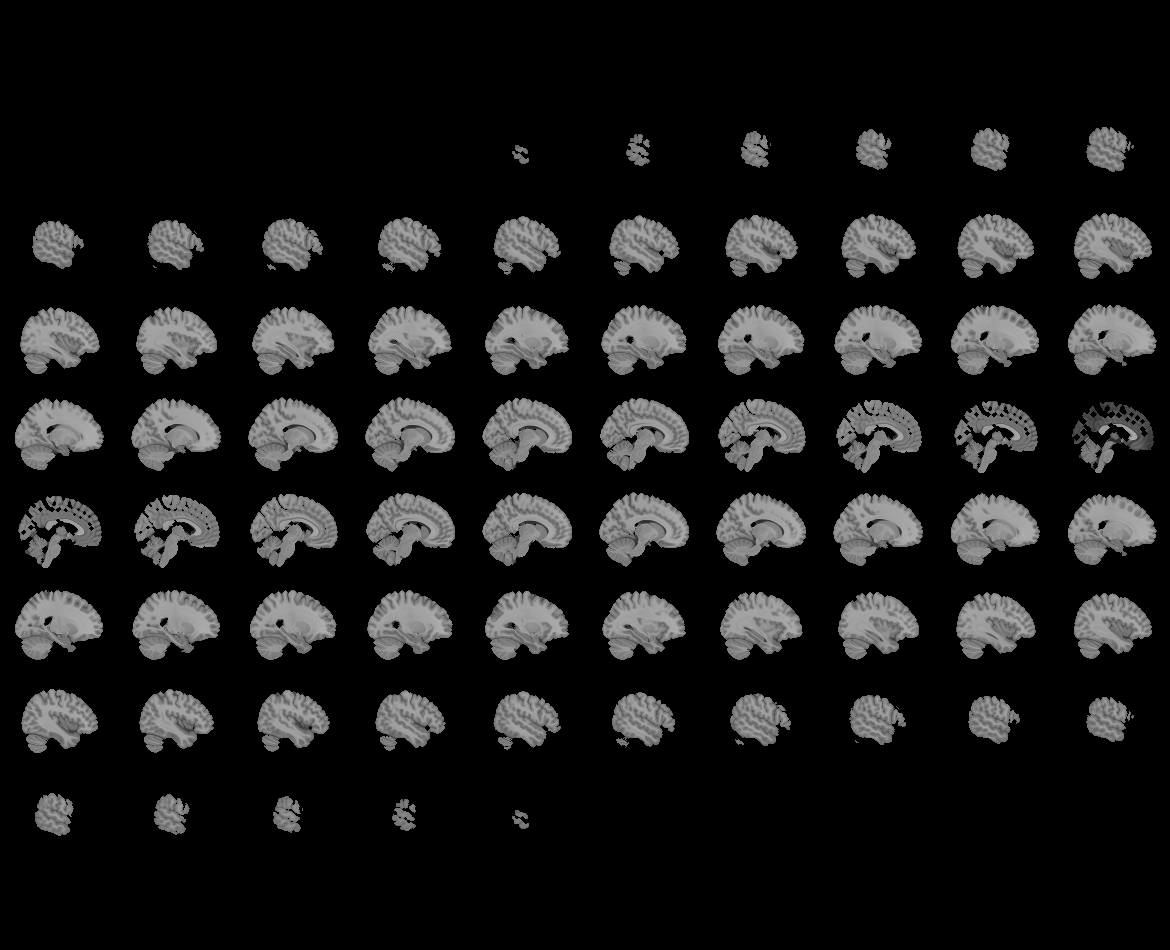
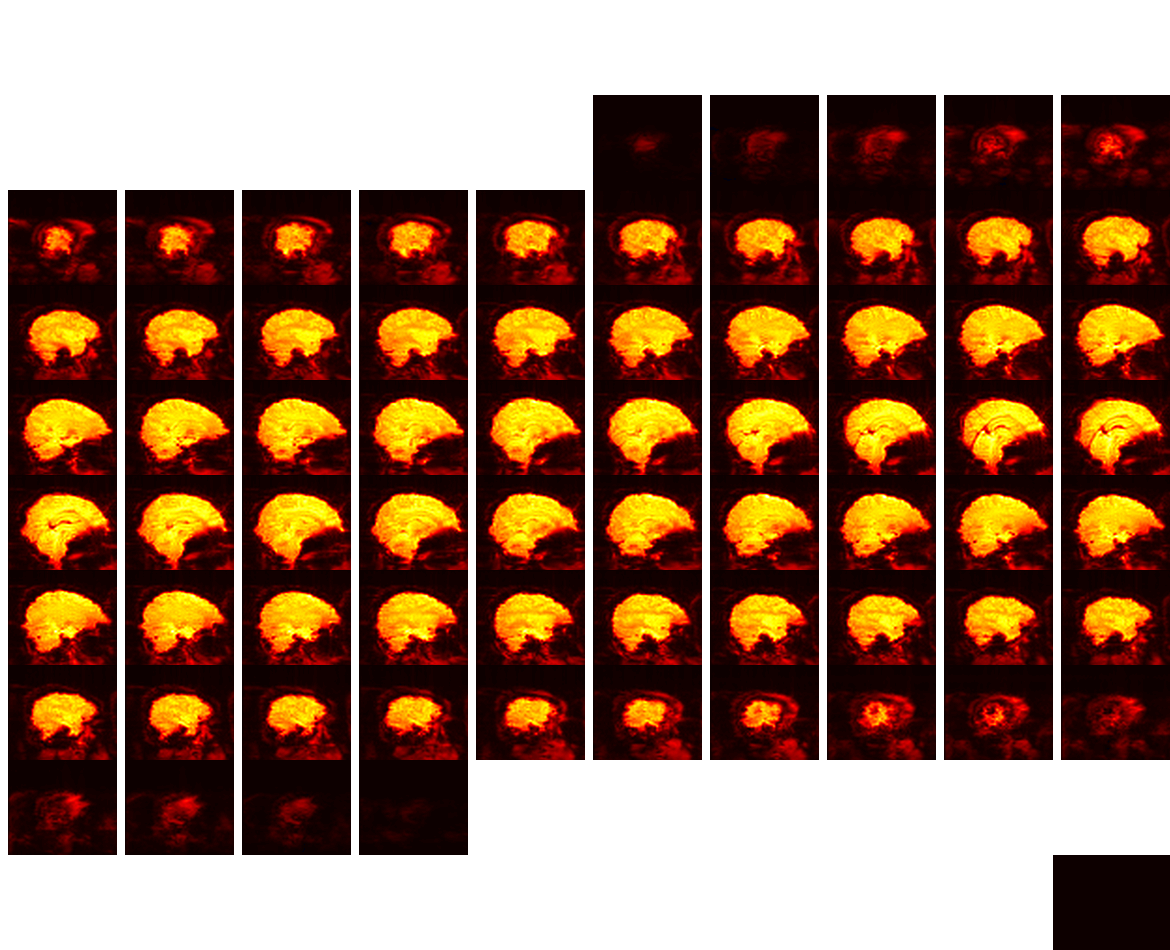

In [2]:
from nilearn import plotting
from nilearn.image import mean_img
plotting.view_img(mean_img(fmri_filename), threshold=None)

## mean = moyenne des activations?

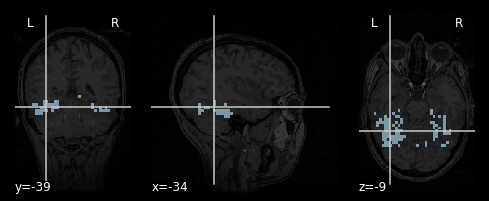

In [3]:
mask_filename = haxby_dataset.mask_vt[0]

# Let's visualize it, using the subject's anatomical image as a
# background
plotting.plot_roi(mask_filename, bg_img=haxby_dataset.anat[0],
                  cmap='Paired')

In [4]:
import pandas as pd
# Load behavioral information
behavioral = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')
print(behavioral)

     labels  chunks
0      rest       0
1      rest       0
2      rest       0
3      rest       0
4      rest       0
...     ...     ...
1447   rest      11
1448   rest      11
1449   rest      11
1450   rest      11
1451   rest      11

[1452 rows x 2 columns]


In [5]:
conditions = behavioral['labels']
print(conditions)

0       rest
1       rest
2       rest
3       rest
4       rest
        ... 
1447    rest
1448    rest
1449    rest
1450    rest
1451    rest
Name: labels, Length: 1452, dtype: object


In [6]:
condition_mask = conditions.isin(['face', 'cat'])

In [7]:
from nilearn.image import index_img
fmri_niimgs = index_img(fmri_filename, condition_mask)

In [8]:
conditions = conditions[condition_mask]
# Convert to numpy array
conditions = conditions.values
print(conditions.shape)

(216,)


In [9]:
from nilearn.decoding import Decoder
decoder = Decoder(estimator='svc', mask=mask_filename, standardize=True)

In [10]:
decoder.fit(fmri_niimgs, conditions)

In [11]:
prediction = decoder.predict(fmri_niimgs)
print(prediction)

['face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'face' 'face' 'face' 'face' 'face' 'face' 'face' '

In [12]:
print((prediction == conditions).sum() / float(len(conditions)))

1.0


In [13]:
fmri_niimgs_train = index_img(fmri_niimgs, slice(0, -30))
fmri_niimgs_test = index_img(fmri_niimgs, slice(-30, None))
conditions_train = conditions[:-30]
conditions_test = conditions[-30:]

decoder = Decoder(estimator='svc', mask=mask_filename, standardize=True)
decoder.fit(fmri_niimgs_train, conditions_train)

prediction = decoder.predict(fmri_niimgs_test)

# The prediction accuracy is calculated on the test data: this is the accuracy
# of our model on examples it hasn't seen to examine how well the model perform
# in general.

print("Prediction Accuracy: {:.3f}".format(
    (prediction == conditions_test).sum() / float(len(conditions_test))))

Prediction Accuracy: 0.767


In [14]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=5)

# The "cv" object's split method can now accept data and create a
# generator which can yield the splits.
fold = 0
for train, test in cv.split(conditions):
    fold += 1
    decoder = Decoder(estimator='svc', mask=mask_filename, standardize=True)
    decoder.fit(index_img(fmri_niimgs, train), conditions[train])
    prediction = decoder.predict(index_img(fmri_niimgs, test))
    print(
        "CV Fold {:01d} | Prediction Accuracy: {:.3f}".format(
            fold,
            (prediction == conditions[test]).sum() / float(len(
                conditions[test]))))

CV Fold 1 | Prediction Accuracy: 0.886
CV Fold 2 | Prediction Accuracy: 0.767
CV Fold 3 | Prediction Accuracy: 0.767
CV Fold 4 | Prediction Accuracy: 0.698
CV Fold 5 | Prediction Accuracy: 0.744


In [15]:
n_folds = 5
decoder = Decoder(
    estimator='svc', mask=mask_filename,
    standardize=True, cv=n_folds,
    scoring='accuracy'
)
decoder.fit(fmri_niimgs, conditions)

In [16]:
print(decoder.cv_params_['face'])

{'C': [100.0, 100.0, 100.0, 100.0, 100.0]}


In [17]:
session_label = behavioral['chunks'][condition_mask]

In [18]:
from sklearn.model_selection import LeaveOneGroupOut
cv = LeaveOneGroupOut()

decoder = Decoder(estimator='svc', mask=mask_filename, standardize=True,
                  cv=cv)
decoder.fit(fmri_niimgs, conditions, groups=session_label)

print(decoder.cv_scores_)

{'cat': [1.0, 1.0, 1.0, 1.0, 0.9629629629629629, 0.8518518518518519, 0.9753086419753086, 0.40740740740740744, 0.9876543209876543, 1.0, 0.9259259259259259, 0.8765432098765432], 'face': [1.0, 1.0, 1.0, 1.0, 0.9629629629629629, 0.8518518518518519, 0.9753086419753086, 0.40740740740740744, 0.9876543209876543, 1.0, 0.9259259259259259, 0.8765432098765432]}


In [19]:
coef_ = decoder.coef_
print(coef_)

[[-3.88470530e-02 -1.86752424e-02 -3.22274463e-02 -2.88103782e-02
   4.17749432e-02  1.10474966e-02  1.69628579e-02 -5.49690152e-02
  -1.93774211e-02 -3.50417353e-02  1.08279682e-02 -1.28501766e-02
  -1.54318467e-02 -3.78043930e-02 -3.68278590e-02  2.27558314e-02
   6.54997292e-03 -7.64042066e-03  1.66730114e-02 -8.00466390e-03
   5.28261722e-02 -8.15726155e-02 -6.35569880e-02  2.40756915e-02
   4.58822875e-02 -2.22076876e-02 -1.76884062e-02  2.21688505e-02
  -9.51040242e-03  5.74704658e-02  2.13813514e-02 -9.12120754e-02
   4.02834954e-03 -2.88625444e-02 -3.88124358e-02 -3.34318609e-02
   2.20847836e-03  8.71170286e-03 -3.36652355e-02 -2.40700156e-02
  -6.80080893e-02  1.65047322e-02  2.70138129e-02 -6.55162961e-03
  -1.21379964e-02  5.46413118e-02  8.11532601e-03  3.60127099e-02
  -1.52387429e-02  7.01266852e-02  1.28205300e-03  2.07522707e-02
  -4.09191306e-03  3.71552030e-02 -3.76543321e-02 -1.03609999e-02
  -2.37698460e-02 -5.47603109e-02  4.41999611e-02 -1.47077288e-01
  -2.33517

In [20]:
print(coef_.shape)

(1, 464)


In [21]:
coef_img = decoder.coef_img_['face']

In [22]:
decoder.coef_img_['face'].to_filename('haxby_svc_weights.nii.gz')


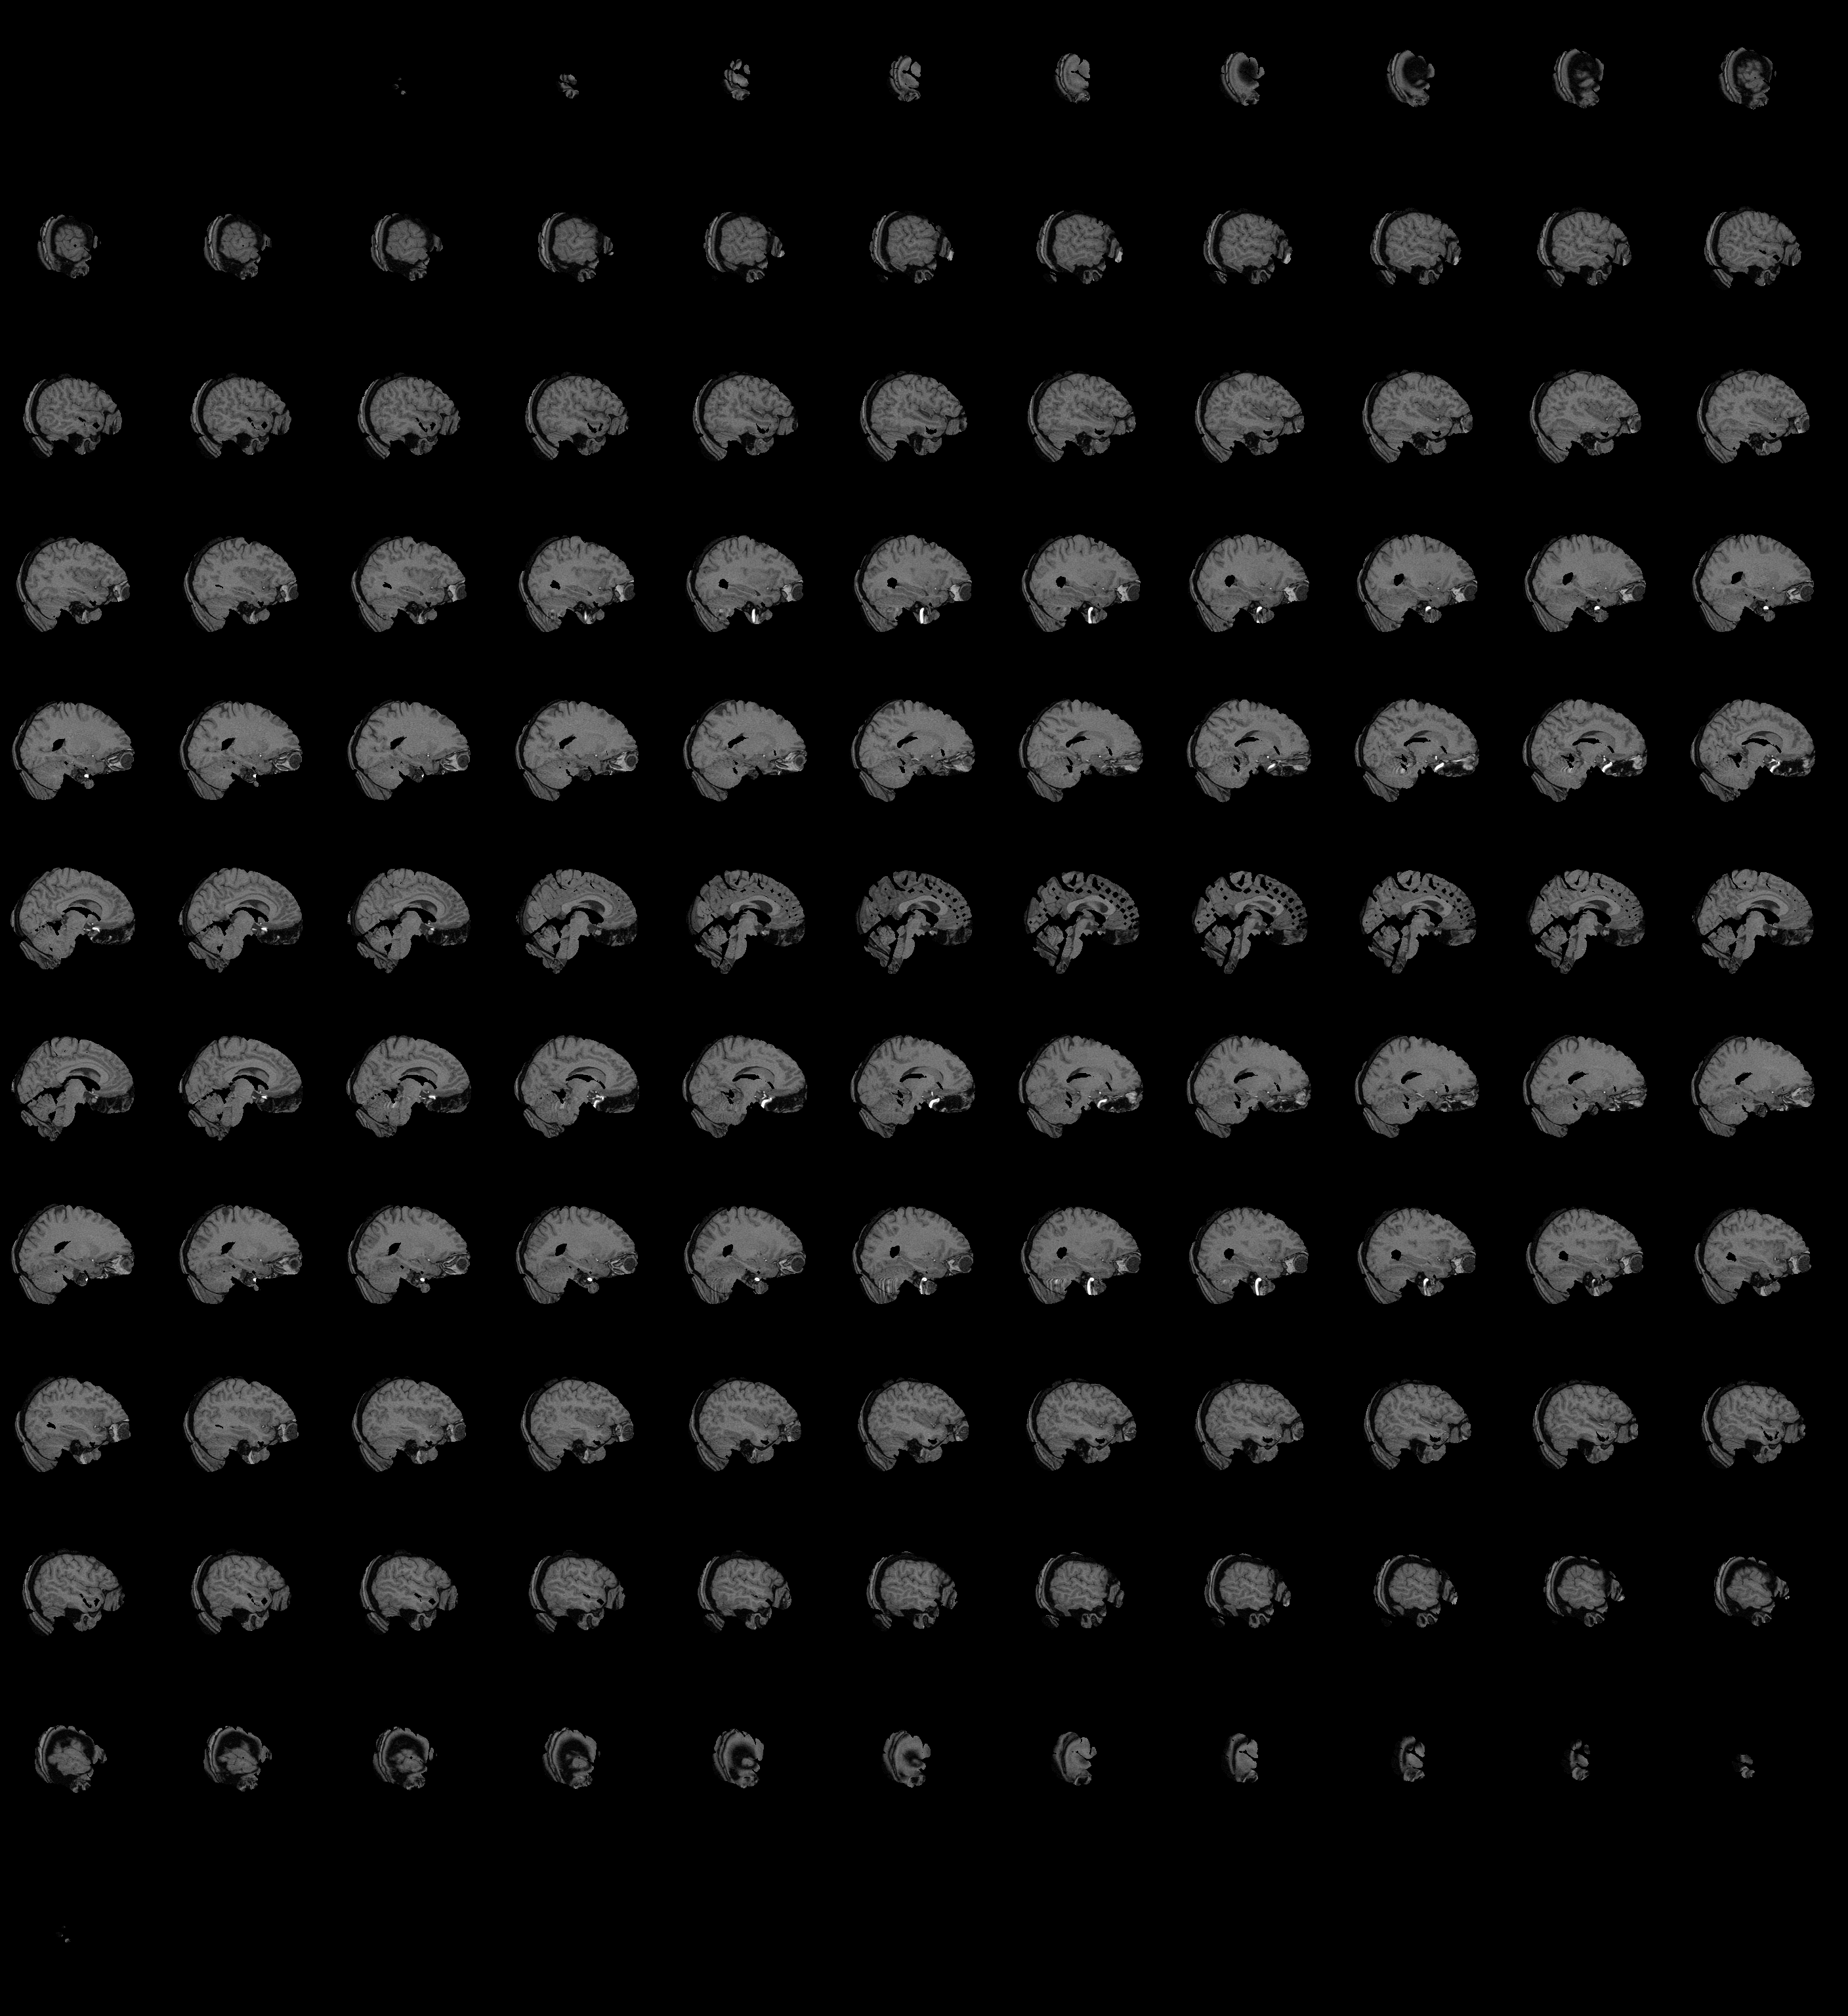
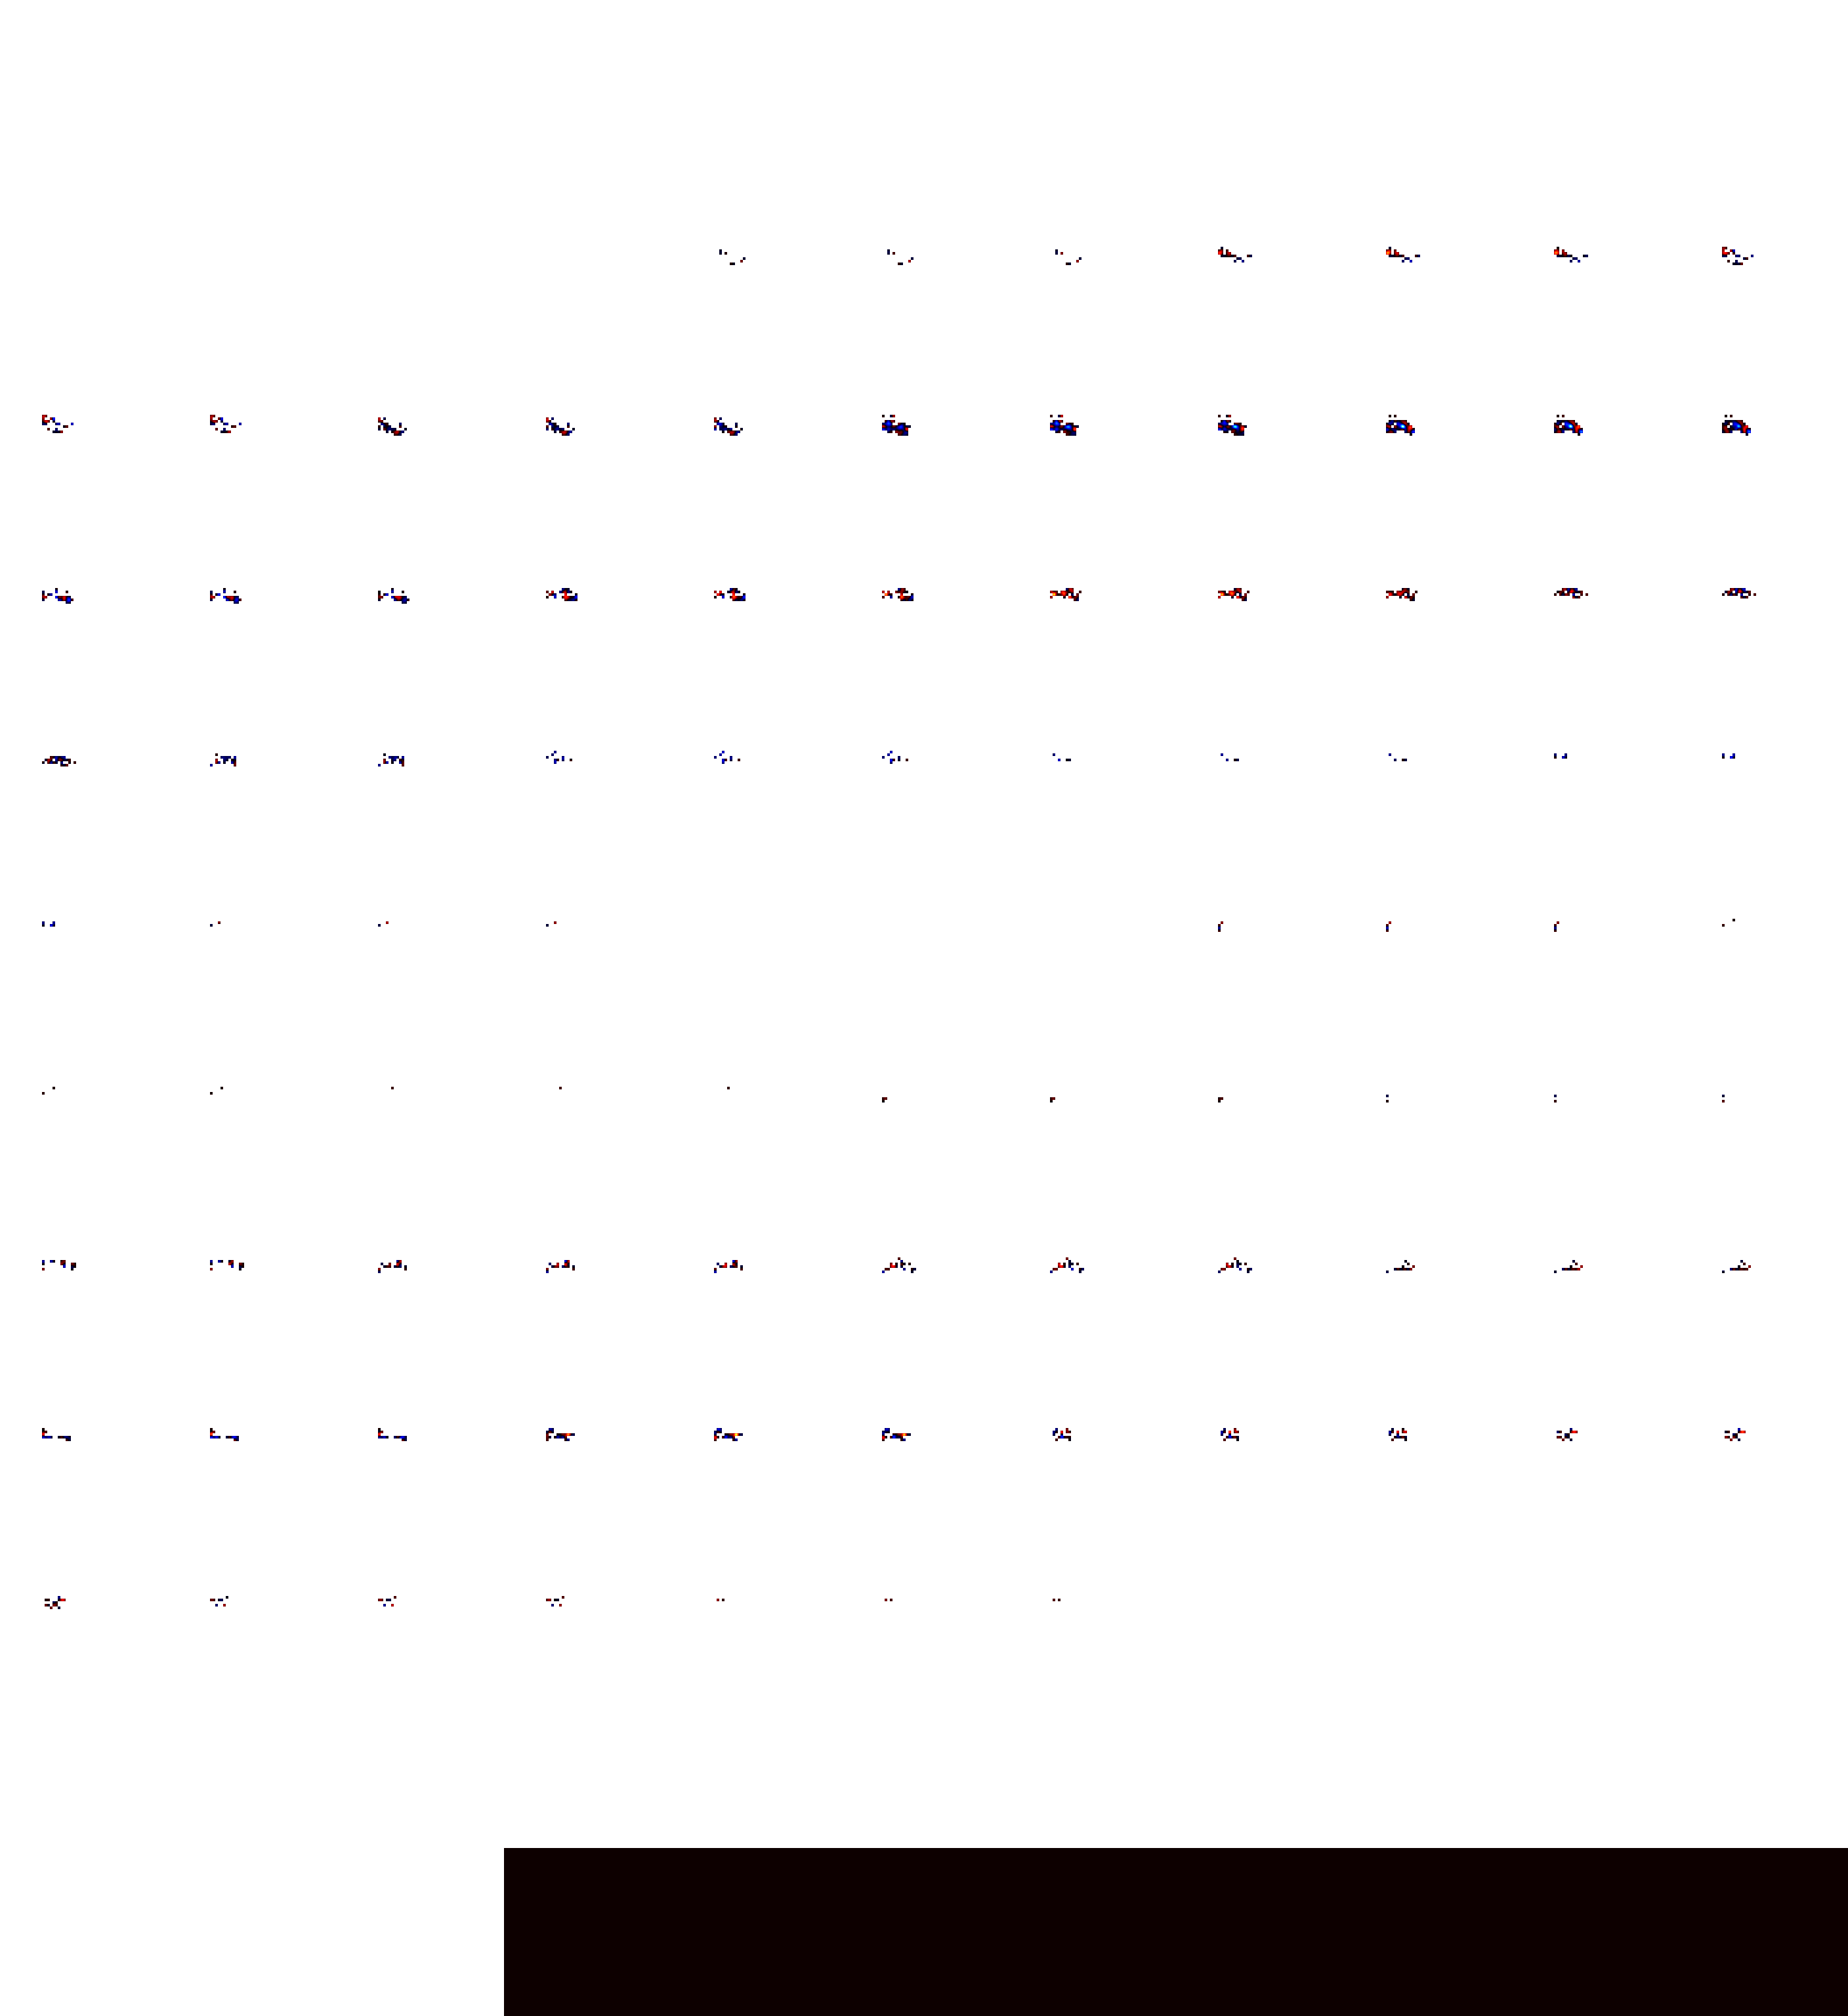

In [23]:
plotting.view_img(
    decoder.coef_img_['face'], bg_img=haxby_dataset.anat[0],
    title="SVM weights", dim=-1
)

In [24]:
dummy_decoder = Decoder(estimator='dummy_classifier', mask=mask_filename,
                        cv=cv)
dummy_decoder.fit(fmri_niimgs, conditions, groups=session_label)

# Now, we can compare these scores by simply taking a mean over folds
print(dummy_decoder.cv_scores_)

{'cat': [0.38888888888888895, 0.38888888888888895, 0.38888888888888895, 0.6111111111111112, 0.38888888888888895, 0.6111111111111112, 0.38888888888888895, 0.38888888888888895, 0.38888888888888895, 0.38888888888888895, 0.6111111111111112, 0.38888888888888895], 'face': [0.38888888888888895, 0.38888888888888895, 0.38888888888888895, 0.6111111111111112, 0.38888888888888895, 0.6111111111111112, 0.38888888888888895, 0.38888888888888895, 0.38888888888888895, 0.38888888888888895, 0.6111111111111112, 0.38888888888888895]}
